In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# 데이터 가져오기
dataset_name = 'cats_vs_dogs'
train_dataset = tfds.load(name=dataset_name,split='train[:80%]', shuffle_files=True)
valid_dataset = tfds.load(name=dataset_name,split='train[80%:]')

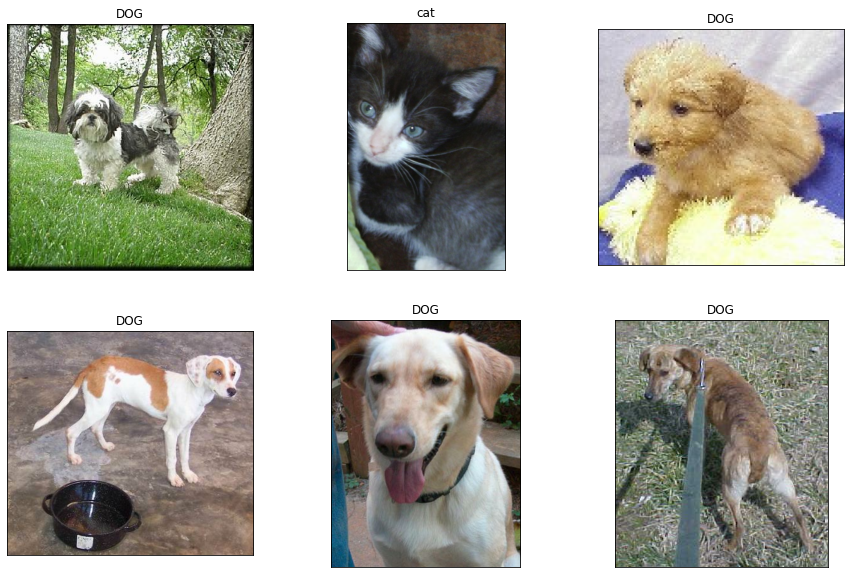

In [3]:
# 데이터 시각화
images = []
labels = []

for data in train_dataset.take(6):
    images.append(data['image'])
    labels.append(data['label'])

fig, axes = plt.subplots(2, 3, figsize = (15, 10))

for idx, ax in enumerate(axes.flat):
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    ax.imshow(images[idx])

    if labels[idx] == 1:
        ax.set_title('DOG')
    else:
        ax.set_title("cat")

In [4]:
# 전처리
def preprocessing(data):
    image = tf.cast(data['image'], dtype=tf.float32)/255.0
    image = tf.image.resize(image, size=(224, 224))
    label = data['label']
    return image, label

train_data = train_dataset.map(preprocessing).batch(32)
valid_data = valid_dataset.map(preprocessing).batch(32)

In [5]:
# 모델링

## transfer_model(VGG16)
transfer = tf.keras.applications.VGG16(weights='imagenet',  # imagenet 가중치 가져오기
                                       include_top=False,   # feature extraction 부분만 가져오기
                                       input_shape=(224, 224, 3))
transfer.trainable = False # 가중치 프리징

model = tf.keras.models.Sequential([
                                    transfer,
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.7),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(2, activation='softmax')
])

In [6]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                802848    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 15,517,602
Trainable params: 802,914
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# 최적화 함수, 손실 함수, 평가지표 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [8]:
# 체크 포인트 설정
checkpoint_path = 'my_checkpont.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True, # 가중치만 저장
                                                save_best_only=True, # 성능 개선이 있을때만 저장
                                                monitor = 'val_loss', # validation_loss값 모니터
                                                verbose=1 # 추적하는것을 화면에 표시
                                                )

In [9]:
hist = model.fit(train_data,
                 validation_data=(valid_data),
                 epochs=20,
                 callbacks=[checkpoint])

Epoch 1/20
582/582 [==============================] - 107s 170ms/step - loss: 0.3011 - acc: 0.8669 - val_loss: 0.1800 - val_acc: 0.9228

Epoch 00001: val_loss improved from inf to 0.18003, saving model to my_checkpont.ckpt
Epoch 2/20
582/582 [==============================] - 98s 168ms/step - loss: 0.2202 - acc: 0.9069 - val_loss: 0.1828 - val_acc: 0.9233

Epoch 00002: val_loss did not improve from 0.18003
Epoch 3/20
582/582 [==============================] - 97s 167ms/step - loss: 0.1951 - acc: 0.9181 - val_loss: 0.1961 - val_acc: 0.9149

Epoch 00003: val_loss did not improve from 0.18003
Epoch 4/20
582/582 [==============================] - 98s 167ms/step - loss: 0.1866 - acc: 0.9244 - val_loss: 0.1678 - val_acc: 0.9295

Epoch 00004: val_loss improved from 0.18003 to 0.16780, saving model to my_checkpont.ckpt
Epoch 5/20
582/582 [==============================] - 97s 167ms/step - loss: 0.1812 - acc: 0.9219 - val_loss: 0.1683 - val_acc: 0.9282

Epoch 00005: val_loss did not improve fro

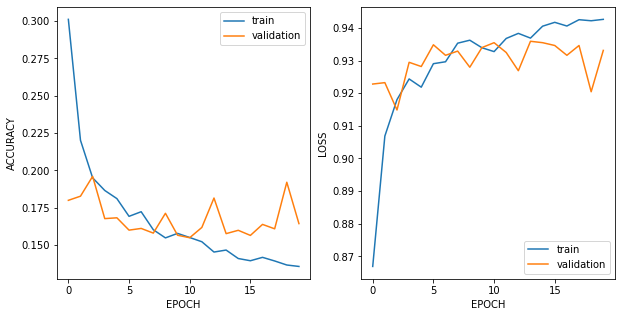

In [15]:
# accury, loss 그래프
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(hist.history['loss'], label='train')
axes[0].plot(hist.history['val_loss'], label='validation')
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('ACCURACY')
axes[0].legend()

axes[1].plot(hist.history['acc'], label='train')
axes[1].plot(hist.history['val_acc'], label='validation')
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('LOSS')
axes[1].legend()

plt.show()

In [16]:
# 모델에 가중치 적용
model.load_weights(checkpoint_path)

In [17]:
# 모델 저장
model.save('cats_vs_dogs.h5')